In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import re
from tabulate import tabulate
import time 
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from string import punctuation
from gensim.models import word2vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGBoostClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import *
from sklearn.feature_selection import SelectKBest

import sklearn.neighbors._base
import warnings
warnings.filterwarnings('ignore')

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
## Reading the csv file
reviews = pd.read_csv("/content/gdrive/MyDrive/Capstone_Vidya/Capstone_Vidya/Capstone_Vidya/sample30.csv")

In [4]:
## Displaying the head
reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


# Data Cleansing and Pre-processing

In [5]:
## Checking the shape of the data frame
reviews.shape

(30000, 15)

In [6]:
## Checking the info of the data set
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [7]:
## Checking for the null value counts
reviews.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [8]:
## Checking the Null value count percentages
round(100*reviews.isnull().sum()/reviews.shape[0],2)

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64

In [9]:
## Dropping the columns reviews_userCity and reviews_userProvince as they have more than 90% null values and seems to be no importance for the analysis
reviews = reviews.drop(['reviews_userCity','reviews_userProvince'],axis=1)
reviews.shape

(30000, 13)

In [10]:
## checking again the null value percentages
round(100*reviews.isnull().sum()/reviews.shape[0],2)

id                      0.00
brand                   0.00
categories              0.00
manufacturer            0.47
name                    0.00
reviews_date            0.15
reviews_didPurchase    46.89
reviews_doRecommend     8.57
reviews_rating          0.00
reviews_text            0.00
reviews_title           0.63
reviews_username        0.21
user_sentiment          0.00
dtype: float64

In [11]:
## Displaying the head
reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [12]:
## Checking the user_sentiment which has null value
reviews[reviews['user_sentiment'].isnull()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,NaN


## Imputing default values for the Null Values

In [13]:
## There are Null values in manufacturer column and we can impute the Brand values as Brand and Manufacturer seems to have similarity
reviews['manufacturer'] = np.where(reviews['manufacturer'].isnull(),reviews['brand'],reviews['manufacturer'])

## There is one record with user_sengtiment as Null and imputed manually with Positive based on the reviews_rating column.
reviews['user_sentiment'] = np.where(reviews['user_sentiment'].isnull(),'Positive',reviews['user_sentiment'])

## reviews_didPurchase and reviews_doRecommend has Null values and I will impute them with "N/A" 
reviews['reviews_didPurchase'] = reviews['reviews_didPurchase'].fillna('N/A')
reviews['reviews_doRecommend'] = reviews['reviews_doRecommend'].fillna('N/A')

## We could see there is null values for Reviews_date and can be imputed with default date.
reviews['reviews_date'] = reviews['reviews_date'].fillna('1969-12-31T00:00:00.000Z')

## There are some records with reviews_username as Null and i will impute with "Anonymus" user.
reviews['reviews_username'] = reviews['reviews_username'].fillna('Anonymus')

## Imputing Niull values in reviews_title with reviews_text as title also has similar text
reviews['reviews_title'] = np.where(reviews['reviews_title'].isnull(),reviews['reviews_text'],reviews['reviews_title'])



In [14]:
def is_date_matching(date_str):
    try:
        return datetime.datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        return datetime.datetime.strptime('1969-12-31', '%Y-%m-%d')

In [15]:
## Extracting date part alone as timestamp part is not required for our analysis
reviews['reviews_date'] = reviews['reviews_date'].apply(lambda x: x.split('T')[0])
## Cleaning date column with proper default date and creating reviews_year column for analysis
reviews['reviews_date'] = reviews['reviews_date'].apply(lambda x: is_date_matching(x))
reviews['reviews_year'] = reviews['reviews_date'].apply(lambda x: x.year)

In [16]:
## Checking for the transformed columns
reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_year
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30,N/A,N/A,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,2012
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09,True,N/A,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,2017
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09,True,N/A,5,Good flavor.,Good,dorothy w,Positive,2017
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,2016
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,2016


## Tranforming Target column

In [17]:
## Tranforming the user_sentiment from Categorical to Numeric as this is our prediction variable
reviews['user_sentiment'] = reviews['user_sentiment'].map({'Positive': 1, 'Negative': 0}).astype('int')

In [18]:
## Lets check again info of the data
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   30000 non-null  object        
 1   brand                30000 non-null  object        
 2   categories           30000 non-null  object        
 3   manufacturer         30000 non-null  object        
 4   name                 30000 non-null  object        
 5   reviews_date         30000 non-null  datetime64[ns]
 6   reviews_didPurchase  30000 non-null  object        
 7   reviews_doRecommend  30000 non-null  object        
 8   reviews_rating       30000 non-null  int64         
 9   reviews_text         30000 non-null  object        
 10  reviews_title        30000 non-null  object        
 11  reviews_username     30000 non-null  object        
 12  user_sentiment       30000 non-null  int64         
 13  reviews_year         30000 non-

# Exploratory Data Analysis

In [21]:
## Checking unique values in the data set
reviews.nunique()

id                       271
brand                    214
categories               270
manufacturer             227
name                     271
reviews_date            2624
reviews_didPurchase        3
reviews_doRecommend        3
reviews_rating             5
reviews_text           27282
reviews_title          18714
reviews_username       24915
user_sentiment             2
reviews_year              13
dtype: int64

In [22]:
## Checking the Anonymus user reviews
reviews[reviews['reviews_username'] == 'Anonymus']['reviews_title'].unique()

array(['Way Basics 3-Shelf Storage Unit in Espresso Wood Grain',
       'Wonderful', 'Smell stays on your skin',
       'Purely for Elvis fans...', "If you like EP, you'll love this one",
       'Best Elvis Movie of All', 'One Size Fits Small', 'Don"t Buy!',
       'Bought This One And Took Back...', 'Effective In Suction',
       'Lve This Vaccuum', 'Love It!', 'Very Light!',
       'Older Is Sometimes Better', 'Best In Class',
       'Platinum Lightweight Bagged Upright', 'Wow! Excellent!',
       'Worth Every Cent ... Really!', 'A Hoover Worth The Investment!',
       'Fabulous Vacuum! (3/15/09)', 'wonderful', 'Love This Product!',
       'Love Them', 'I Love The Smell.', 'Awesome', 'Clorox',
       'Clorox Wipes Helps Eliminate Germs From Community Property.',
       'Love This Product', 'This Product Is Great.', 'Love The Smell',
       'This Is My Favorite Cleaning Product', 'Love It!!!!',
       'Disinfects And Smells Great', 'Love This!!!!',
       'Great Cleaning Wipe!', 'Awes

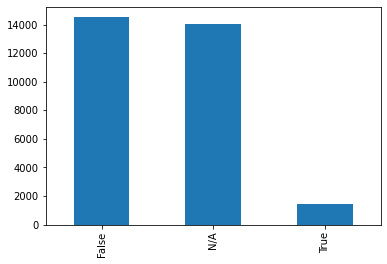

In [23]:
## Checking distinct values in reviews_didPurchase
## There is very less percentage of the reviews came from the purchased customers
reviews['reviews_didPurchase'].value_counts().plot(kind = "bar")

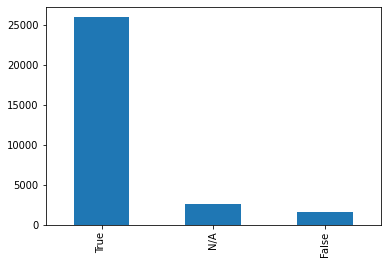

In [24]:
## Checking the distinct values in reviews_doRecommend
## Most of the reviews recommend the product.
## Though purchased users are less, recommnded users count is more
reviews['reviews_doRecommend'].value_counts().plot(kind = "bar")

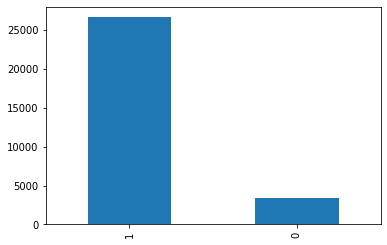

In [25]:
## Checking the users sentiment distribution
## 90% of the users shows positive sentiment
reviews['user_sentiment'].value_counts().plot(kind = "bar")

In [26]:
## Checking the ratings distinct values and its counts
## ratings are majorly coming for 5 and 4 which actually shows the positive sentiment
reviews['reviews_rating'].value_counts()

5    20831
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

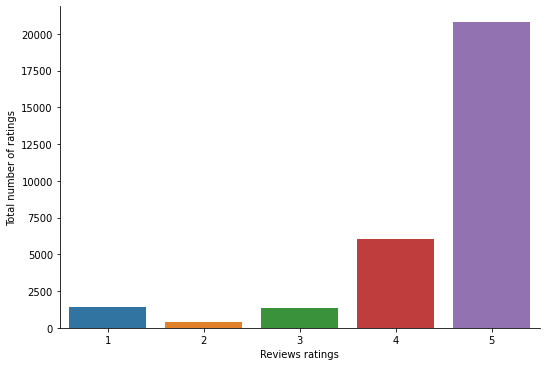

In [27]:
# Visualising the distribution of the rating
f = sns.factorplot("reviews_rating", data=reviews, aspect=1.5,kind='count')
f.set_xlabels("Reviews ratings")
f.set_ylabels("Total number of ratings")

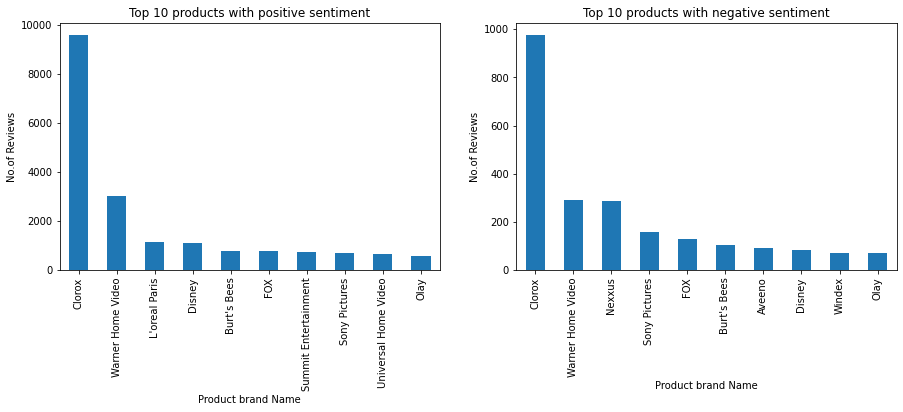

In [28]:
## Checking top 10 brands contribute to the positive and negative sentiments
## If we observe both positive and negative sentiments has similar products contribute most
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.title("Top 10 products with positive sentiment")
plt.xlabel("Product brand Name")
plt.ylabel("No.of Reviews")
reviews[reviews['user_sentiment'] == 1]['brand'].value_counts()[:10].plot(kind = "bar")
# plt.xticks(rotation=60)

plt.subplot(2,2,2)
plt.title("Top 10 products with negative sentiment")
plt.xlabel("Product brand Name")
plt.ylabel("No.of Reviews")
reviews[reviews['user_sentiment'] == 0]['brand'].value_counts()[:10].plot(kind = "bar")
# plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

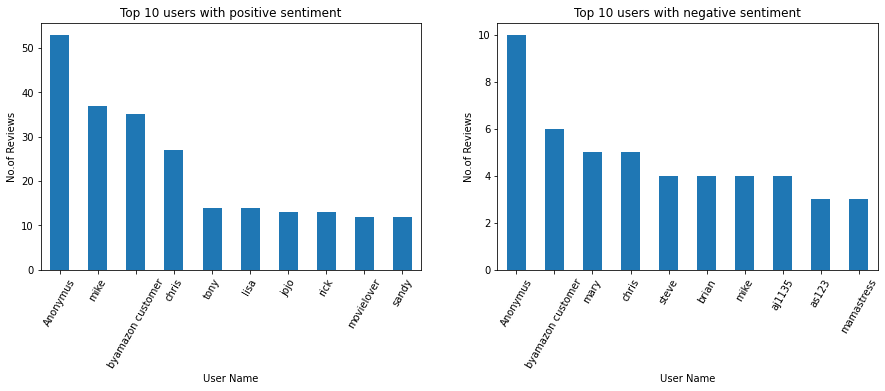

In [29]:
## Checking the top 10 users who has given more positive and negative reviews
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.title("Top 10 users with positive sentiment")
plt.xlabel("User Name")
plt.ylabel("No.of Reviews")
reviews[reviews['user_sentiment'] == 1]['reviews_username'].value_counts()[:10].plot(kind = "bar")
plt.xticks(rotation=60)

plt.subplot(2,2,2)
plt.title("Top 10 users with negative sentiment")
plt.xlabel("User Name")
plt.ylabel("No.of Reviews")
reviews[reviews['user_sentiment'] == 0]['reviews_username'].value_counts()[:10].plot(kind = "bar")
plt.xticks(rotation=60)


In [30]:
## Checking for the products which are rated positive for the user 'mike'
reviews[(reviews['reviews_username'] == 'mike') & (reviews['user_sentiment'] == 1)]['brand'].value_counts()

Warner Home Video       15
FOX                      4
Disney                   3
Warner Music Group       3
Universal Home Video     2
Meguiars                 2
Clorox                   2
Tostitos                 1
Lionsgate                1
Chester's                1
Banana Boat              1
South Shore              1
Warner Bros.             1
Name: brand, dtype: int64

In [31]:
## Checking for the products which are rated negative for the user 'mike'
reviews[(reviews['reviews_username'] == 'mike') & (reviews['user_sentiment'] == 0)]['brand'].value_counts()

FOX       2
Feit      1
Disney    1
Name: brand, dtype: int64

In [32]:
## Checking for the products which are rated positive for the user 'byamazon customer'
reviews[(reviews['reviews_username'] == 'byamazon customer') & (reviews['user_sentiment'] == 1)]['brand'].value_counts()

Lundberg    19
Aveeno      16
Name: brand, dtype: int64

In [33]:
## Checking for the products which are rated negative for the user 'byamazon customer'
reviews[(reviews['reviews_username'] == 'byamazon customer') & (reviews['user_sentiment'] == 0)]['brand'].value_counts()

Aveeno    6
Name: brand, dtype: int64

In [34]:
## Checking for the products which are rated positive for the user 'chris'
reviews[(reviews['reviews_username'] == 'chris') & (reviews['user_sentiment'] == 1)]['brand'].value_counts()

Warner Home Video       8
FOX                     4
Disney                  3
Sony Pictures           3
Warner Bros.            2
Universal Home Video    1
Hormel                  1
Feit                    1
Hunter Fan              1
Warner Music Group      1
Windex                  1
Storkcraft              1
Name: brand, dtype: int64

In [35]:
## Checking for the products which are rated negative for the user 'chris'
reviews[(reviews['reviews_username'] == 'chris') & (reviews['user_sentiment'] == 0)]['brand'].value_counts()

Sony Pictures        2
Weather Tech         1
FOX                  1
Warner Home Video    1
Name: brand, dtype: int64

### Above analysis shows same user has given positive as well as negative ratings for the same product. Lets analyze based on the review year

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

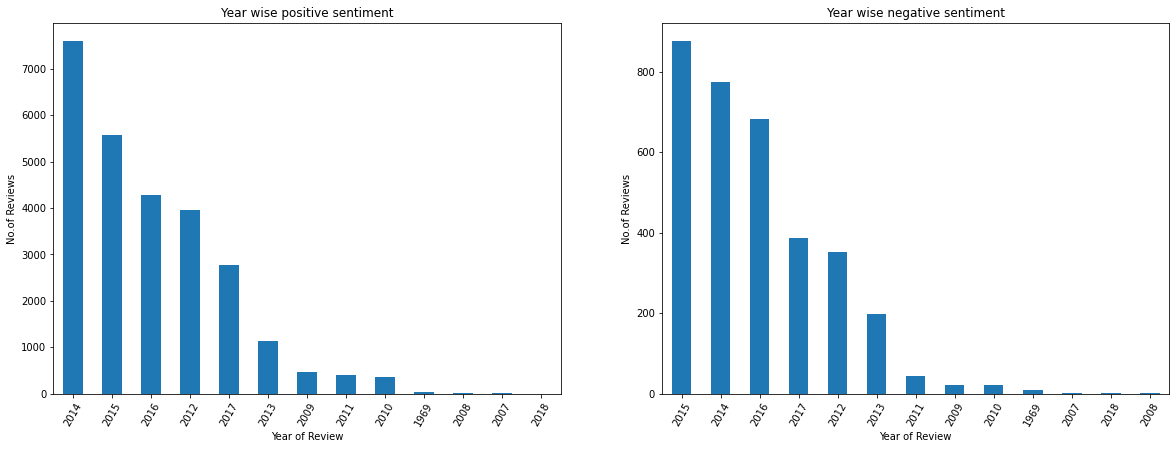

In [36]:
## Checking the year wise positive and negative reviews
plt.figure(figsize = (20,15))
plt.subplot(2,2,1)
plt.title("Year wise positive sentiment")
plt.xlabel("Year of Review")
plt.ylabel("No.of Reviews")
reviews[reviews['user_sentiment'] == 1]['reviews_year'].value_counts().plot(kind = "bar")
plt.xticks(rotation=60)

plt.subplot(2,2,2)
plt.title("Year wise negative sentiment")
plt.xlabel("Year of Review")
plt.ylabel("No.of Reviews")
reviews[reviews['user_sentiment'] == 0]['reviews_year'].value_counts().plot(kind = "bar")
plt.xticks(rotation=60)

In [40]:
## Checking the words contributed for the positive and negative sentiments
## First lets convert the reviews text to lower
positive_review = reviews[reviews['user_sentiment'] == 1]['reviews_text'].str.lower()
negative_review = reviews[reviews['user_sentiment'] == 0]['reviews_text'].str.lower()

In [41]:
## Getting the stowords from nltk for Text analysis
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(-0.5, 1199.5, 599.5, -0.5)

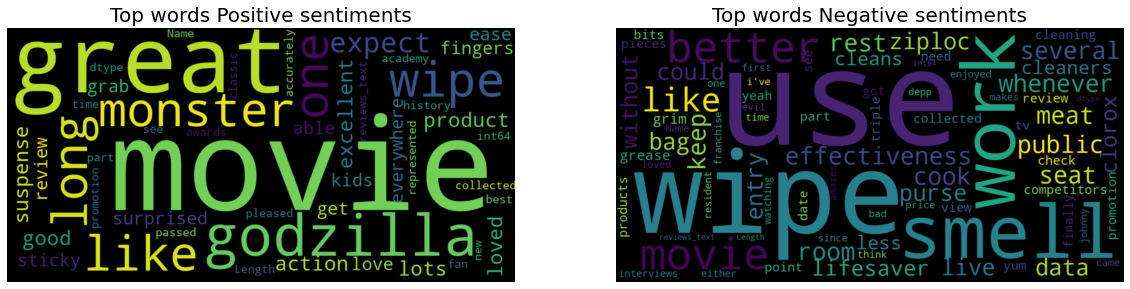

In [42]:
## Using Wordcloud to see the top words present in positive and negative sentiments
wordcloud_pos = WordCloud(background_color='black', stopwords=stop_words, max_words=500, max_font_size=None,
                     scale=3, random_state=1).generate(str(positive_review.value_counts()))
wordcloud_neg = WordCloud(background_color='black', stopwords=stop_words, max_words=500, max_font_size=None,
                     scale=3, random_state=1).generate(str(negative_review.value_counts()))

## Visulaising the positive and negative sentiment words

fig, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[0].set_title('Top words Positive sentiments',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_neg, interpolation='bilinear')
ax[1].set_title('Top words Negative sentiments',fontsize = 20)
ax[1].axis("off")

### Based on wordcloud visulisation we see reviews for positive sentiments are well recognised by the words great,good etc.,However, negative sentiment reviews is not clearly giving insights of the words.

In [43]:
## Lets check on the top reviews 
reviews['reviews_text'].value_counts()

Great                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             16
Good                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              1

In [44]:
## Lets check on the top reviews 
reviews['reviews_title'].value_counts()

Great Product                              384
Great movie                                361
Clorox Wipes                               278
Great                                      221
Great product                              205
                                          ... 
One of my Favorites!                         1
great topping for my hot dog                 1
FINALLY ALL 5 ON BRAY                        1
I keep them stashed all over the house!      1
Many Use Folders                             1
Name: reviews_title, Length: 18714, dtype: int64

(-0.5, 1199.5, 599.5, -0.5)

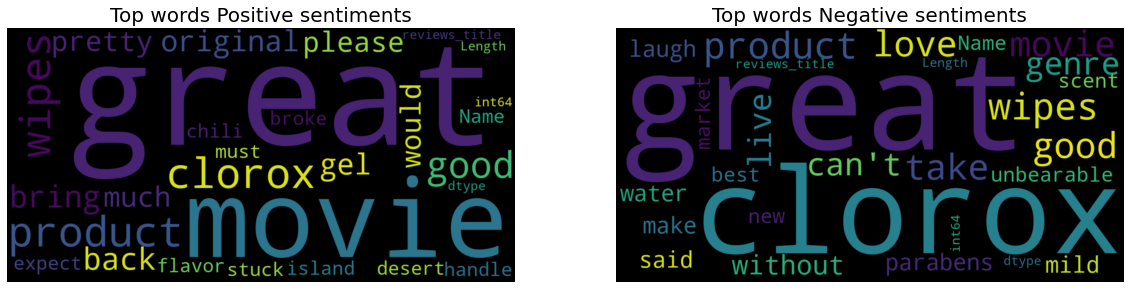

In [45]:
## We will do the similar anlysis on review_title as well
## Checking the words contributed for the positive and negative sentiments
## First lets convert the reviews text to lower
positive_review_title = reviews[reviews['user_sentiment'] == 1]['reviews_title'].str.lower()
negative_review_title = reviews[reviews['user_sentiment'] == 0]['reviews_title'].str.lower()

## Using Wordcloud to see the top words present in positive and negative sentiments
wordcloud_pos = WordCloud(background_color='black', stopwords=stop_words, max_words=500, max_font_size=None,
                     scale=3, random_state=1).generate(str(positive_review_title.value_counts()))
wordcloud_neg = WordCloud(background_color='black', stopwords=stop_words, max_words=500, max_font_size=None,
                     scale=3, random_state=1).generate(str(negative_review_title.value_counts()))

## Visulaising the positive and negative sentiment words

fig, ax = plt.subplots(1,2, figsize=(20, 20))
ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[0].set_title('Top words Positive sentiments',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_neg, interpolation='bilinear')
ax[1].set_title('Top words Negative sentiments',fontsize = 20)
ax[1].axis("off")


### Based on the above visulisation we see review title for positive sentiments are well recognised by the words great,good etc.,However, negative sentiment reviews also shows great. So we need to use some vecotorization method to extract the better features

# Model Building

In [51]:
## Assigning X,y,seed values for the model building 
seed = 42
X = reviews['reviews_text']
y = reviews['user_sentiment']

In [45]:
## Pre-processing the reviews_text
## Keeping only alphabets which are necessary for classification. Also convert the text to lower case
X = X.apply(lambda x: re.sub('[^a-zA-Z]+', ' ', x.lower()).strip())

In [46]:
## Applying Lemmatization to the review_text
from textblob import Word
nltk.download('wordnet')
X_lemma = X.apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Feature Extraction
## I will try out below vecotrization methods 

*   CountVectorizer
*   TF-IDF
*   Pre-trained Glove embeddings
*   Word2Vec

### Count Vectorization

In [48]:
## Getting the features with 1-gram
count_vec = CountVectorizer(max_features=None, lowercase=True, analyzer='word', stop_words= stop_words, ngram_range=(1, 1))
X_count = count_vec.fit_transform(X)

## Checking words
list(count_vec.vocabulary_.items())[:10]

[('love', 8762),
 ('album', 409),
 ('good', 6488),
 ('hip', 7121),
 ('hop', 7207),
 ('side', 13442),
 ('current', 3614),
 ('pop', 11069),
 ('sound', 13868),
 ('hype', 7368)]

## TF-IDF

In [49]:
## Getting the features
tfidf_vec = TfidfVectorizer(max_features=None, lowercase=True, analyzer='word', stop_words= stop_words, ngram_range=(1, 1))
X_tfidf = tfidf_vec.fit_transform(X)
list(tfidf_vec.vocabulary_.items())[:10]

[('love', 8762),
 ('album', 409),
 ('good', 6488),
 ('hip', 7121),
 ('hop', 7207),
 ('side', 13442),
 ('current', 3614),
 ('pop', 11069),
 ('sound', 13868),
 ('hype', 7368)]

In [50]:
## Creating function for basic structure for the model to execute
def model_fit(X, y, ml_model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
    clf = ml_model.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    model_performance = classification_report(y_test, clf_pred)
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    coef = clf.coef_.tolist()[0]
    return coef


# Logistic Regression with CountVectorizer

In [51]:
## Model exceution
count_coef = model_fit(X_count, y, LogisticRegression(penalty="l2", random_state=seed, max_iter=500))

accuracy of the model:  0.9521666666666667

              precision    recall  f1-score   support

           0       0.83      0.71      0.76       651
           1       0.97      0.98      0.97      5349

    accuracy                           0.95      6000
   macro avg       0.90      0.85      0.87      6000
weighted avg       0.95      0.95      0.95      6000



In [52]:
## Getting the top features
w_count = count_vec.get_feature_names()
coeff_df = pd.DataFrame({'Word' : w_count, 'Coefficient' : count_coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('Top 10 positive features (variables)')
print(coeff_df.head(20).to_string(index=False))
print('')
print('Top 10 negative features (variables)')        
print(coeff_df.tail(20).to_string(index=False))


Top 10 positive features (variables)
      Word  Coefficient
      best     4.652857
     great     4.631965
 excellent     3.885684
      love     3.690927
     loved     3.642213
      good     3.571969
      easy     3.526145
      nice     3.524003
   perfect     3.506322
   amazing     3.422645
   awesome     3.316046
 effective     3.156285
  favorite     3.144920
   enjoyed     3.093903
     clean     2.935041
     handy     2.913371
      many     2.879957
 wonderful     2.781804
    better     2.727294
      glad     2.626921

Top 10 negative features (variables)
         Word  Coefficient
         base    -1.981989
        crude    -2.077977
       cheesy    -2.263553
         cold    -2.267613
       boring    -2.302752
     annoying    -2.382530
        wrong    -2.535085
          bad    -2.536104
        crazy    -2.615736
       stupid    -2.723466
         evil    -3.074254
         hate    -3.228882
 disappointed    -3.337525
        dirty    -3.434682
        awful  

### Above model performed very well with Accuracy as 95% and also the features were also identified properly. Lets check on TF-IDF as well to see if we have any better improvement

# Logistic Regression with TF-IDF

In [53]:
## Model execution
tfidf_coef = model_fit(X_tfidf, y, LogisticRegression(penalty="l2", random_state=seed, max_iter=500,solver='lbfgs'))

accuracy of the model:  0.9193333333333333

              precision    recall  f1-score   support

           0       0.91      0.28      0.43       651
           1       0.92      1.00      0.96      5349

    accuracy                           0.92      6000
   macro avg       0.92      0.64      0.69      6000
weighted avg       0.92      0.92      0.90      6000



In [54]:
## Extracting the top features
w_tfidf = tfidf_vec.get_feature_names()
coeff_df = pd.DataFrame({'Word' : w_tfidf, 'Coefficient' : tfidf_coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('Top 10 positive features (variables)')
print(coeff_df.head(20).to_string(index=False))
print('')
print('Top 10 negative features (variables)')        
print(coeff_df.tail(20).to_string(index=False))


Top 10 positive features (variables)
      Word  Coefficient
     great    14.299975
      love    12.265855
      good     8.943166
      best     8.339365
     clean     8.285203
      easy     7.831453
     loved     5.666643
    better     5.602791
      nice     5.225948
 excellent     4.937166
   perfect     4.904090
      many     4.744545
   awesome     4.659487
  favorite     4.620555
   amazing     4.526317
    really     4.234522
   enjoyed     4.177765
      free     3.748947
 wonderful     3.537120
     fresh     3.353136

Top 10 negative features (variables)
         Word  Coefficient
         poor    -1.789105
        crude    -1.933269
       stupid    -2.138372
          sad    -2.236012
       boring    -2.501590
        crazy    -2.527398
         cold    -3.058746
         hate    -3.105926
     resident    -3.235278
        wrong    -3.294038
        worst    -3.657021
        dirty    -3.837502
        nasty    -3.891858
         evil    -4.102983
        awful  

## Tf-IDF performed little lower than Count vectors. However, accuracy is better with 91.9% and also features were almost same for both the methods.

## Lets now check if we have class imbalance

In [55]:
# Checking class imbalnce is present or not
y.value_counts()

1    26633
0     3367
Name: user_sentiment, dtype: int64

## Above clearly shows there is imbalance in the sentiments. I will apply SMOTE tecnique to overcome that after splitting into Train and Test daat sets.

In [56]:
## Creating the model function for Smote and model fitting
def model_fit_class_imbalance(X, y, ml_model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)
    sm = SMOTE()
  
    X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
    X_test_smote, y_test_smote = sm.fit_sample(X_test, y_test)
  
    clf = ml_model.fit(X_train_smote, y_train_smote)
    y_pred = clf.predict(X_test_smote)

    accuracy = clf.score(X_test_smote, y_test_smote)
    model_performance = classification_report(y_test_smote, y_pred)

    y_pred_proba = clf.predict_proba(X_test_smote)
    roc_auc = roc_auc_score(y_test_smote, y_pred_proba[:,1])
    fpr, tpr, _ = roc_curve(y_test_smote, y_pred_proba[:,1])
    ## For evaluating the model
    model_eval_score = cross_val_score(ml_model, X, y, scoring='roc_auc', cv=5).mean()
    
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    print('')
    print('ROC_AUC score: ', roc_auc)
    return (accuracy,roc_auc,model_eval_score,fpr, tpr)

In [57]:
## Executing the models after applying SMOTE
print("\n Logestic Regression with Count Vectorizer \n")
logreg_countVec = model_fit_class_imbalance(X_count, y, LogisticRegression(penalty="l2", random_state=seed, max_iter=500))
print("\n Logestic Regression with TF-IDF Vectorizer \n")
logreg_tfidfVec = model_fit_class_imbalance(X_tfidf, y, LogisticRegression(penalty="l2", random_state=seed, max_iter=500))


 Logestic Regression with Count Vectorizer 

accuracy of the model:  0.9566274069919611

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5349
           1       0.96      0.96      0.96      5349

    accuracy                           0.96     10698
   macro avg       0.96      0.96      0.96     10698
weighted avg       0.96      0.96      0.96     10698


ROC_AUC score:  0.9883918352430874

 Logestic Regression with TF-IDF Vectorizer 

accuracy of the model:  0.9266217984670032

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      5349
           1       0.93      0.92      0.93      5349

    accuracy                           0.93     10698
   macro avg       0.93      0.93      0.93     10698
weighted avg       0.93      0.93      0.93     10698


ROC_AUC score:  0.9738641234083796


## After treating the data for class imbalance we could see there is improvement in the model scores, especially for the Recall.

## Pre-trained embeddings - Glove

In [58]:
## Lets try now using Glove embeddings

X_text = np.array([sent.split() for sent in X],dtype=object)
X_text.shape

(30000,)

In [59]:
## Getting the Glove pre-trained word embeddings
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '/content/gdrive/MyDrive/Capstone_Vidya/Capstone_Vidya/Capstone_Vidya/glove.6B.200d.txt'
word2vec_output_file = '/content/gdrive/MyDrive/Capstone_Vidya/Capstone_Vidya/Capstone_Vidya/glove.6B.200d.w2vformat.txt'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 200)

In [60]:
## Load the model
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("/content/gdrive/MyDrive/Capstone_Vidya/Capstone_Vidya/Capstone_Vidya/glove.6B.200d.w2vformat.txt", binary=False)

In [61]:
def sent_vec(sent):
    wv_res = np.zeros(glove_model.vector_size)
    ctr = 1
    for w in sent:
        if w in glove_model:
            ctr += 1
            wv_res += glove_model[w]
    wv_res = wv_res/ctr
    return wv_res

In [62]:
## Getting X features
X_glove = []
for doc in X_text:    
    doc_words = [term for term in doc if term not in stop_words]
    X_glove.append(sent_vec(doc_words))

In [63]:
## Executing the Logistic Regression model
print("\n Logestic Regression with pre-trained Glove embeddings \n")
logreg_gloveVec = model_fit_class_imbalance(X_glove, y, LogisticRegression(penalty="l2", random_state=seed, max_iter=500))


 Logestic Regression with pre-trained Glove embeddings 

accuracy of the model:  0.8454851374088614

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      5349
           1       0.86      0.83      0.84      5349

    accuracy                           0.85     10698
   macro avg       0.85      0.85      0.85     10698
weighted avg       0.85      0.85      0.85     10698


ROC_AUC score:  0.9062682737098584


## Above model performed good but lets see how model performs if we add our data set words also and use word2vec

In [64]:
## Applying word2vec on our data set and see if its trying to predict the similarity
w2v = word2vec.Word2Vec(X_text, window=2, min_count=2, sg = 1, size=200)
w2v.wv.most_similar("enjoyed", topn=5)

[('liked', 0.885113000869751),
 ('loved', 0.8077728748321533),
 ('enjoy', 0.7597178220748901),
 ('watched', 0.7044340968132019),
 ('missed', 0.6966286301612854)]

In [65]:
def sent_vec_w2v(sent):
    wv_res = np.zeros(w2v.wv.vector_size)
    ctr = 1
    for w in sent:
        if w in w2v.wv:
            ctr += 1
            wv_res += w2v.wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [66]:
## Geeting X data set
X_w2v = []
for doc in X_text:    
    doc_words = [term for term in doc if term not in stop_words]
    X_w2v.append(sent_vec_w2v(doc_words))

In [67]:
## Executing Logistic Regression with word2vec
print("\n Logestic Regression with Word2Vec embeddings \n")
logreg_w2Vec = model_fit_class_imbalance(X_w2v, y, LogisticRegression(penalty="l2", random_state=seed, max_iter=500))


 Logestic Regression with Word2Vec embeddings 

accuracy of the model:  0.839970087866891

              precision    recall  f1-score   support

           0       0.82      0.87      0.85      5349
           1       0.86      0.81      0.83      5349

    accuracy                           0.84     10698
   macro avg       0.84      0.84      0.84     10698
weighted avg       0.84      0.84      0.84     10698


ROC_AUC score:  0.9092903484125309


### We are not seeing any improvement using our data set embeddings.

## We will see how Naive bayes models perform on the data set

In [68]:
print("\n Bernoulli Naive Bayes with Count Vectorizer \n")
bern_nb_countVec = model_fit_class_imbalance(X_count, y, BernoulliNB())
print("\n Bernoulli Naive Bayes with TF-IDF Vectorizer \n")
bern_nb_tfidfVec = model_fit_class_imbalance(X_tfidf, y, BernoulliNB())
print("\n MultiNomial Naive Bayes with Count Vectorizer \n")
multi_nb_countVec = model_fit_class_imbalance(X_count, y, MultinomialNB())
print("\n MultiNomial Naive Bayes with TF-IDF Vectorizer \n")
multi_nb_tfidfVec = model_fit_class_imbalance(X_tfidf, y, MultinomialNB())


 Bernoulli Naive Bayes with Count Vectorizer 

accuracy of the model:  0.8775472050850627

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      5349
           1       0.92      0.82      0.87      5349

    accuracy                           0.88     10698
   macro avg       0.88      0.88      0.88     10698
weighted avg       0.88      0.88      0.88     10698


ROC_AUC score:  0.9565197241515833

 Bernoulli Naive Bayes with TF-IDF Vectorizer 

accuracy of the model:  0.734997195737521

              precision    recall  f1-score   support

           0       0.88      0.54      0.67      5349
           1       0.67      0.93      0.78      5349

    accuracy                           0.73     10698
   macro avg       0.78      0.73      0.72     10698
weighted avg       0.78      0.73      0.72     10698


ROC_AUC score:  0.8726788816964022

 MultiNomial Naive Bayes with Count Vectorizer 

accuracy of the model:  0.88184707421948

## Naive Bayes is showing less accuracy than LR models. Lets check on Random Forest models

In [69]:
print("\n Random Forest with Count Vectorizer \n")
randForest_countVec = model_fit_class_imbalance(X_count, y, RandomForestClassifier(n_estimators=200,n_jobs=-1, random_state=seed))
print("\n Random Forest with TF-IDF Vectorizer \n")
randForest_tfidfVec = model_fit_class_imbalance(X_tfidf, y, RandomForestClassifier(n_estimators=200,n_jobs=-1, random_state=seed))


 Random Forest with Count Vectorizer 

accuracy of the model:  0.9512993082819219

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      5349
           1       0.93      0.97      0.95      5349

    accuracy                           0.95     10698
   macro avg       0.95      0.95      0.95     10698
weighted avg       0.95      0.95      0.95     10698


ROC_AUC score:  0.9832572056544079

 Random Forest with TF-IDF Vectorizer 

accuracy of the model:  0.8911946158160404

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      5349
           1       0.84      0.97      0.90      5349

    accuracy                           0.89     10698
   macro avg       0.90      0.89      0.89     10698
weighted avg       0.90      0.89      0.89     10698


ROC_AUC score:  0.9751854313540067


## Random Forst models showing better results than Naive bayes and similar scores as Logistic. Lets now try XGBoost as well

In [70]:
print("\n XGBoost with Count Vectorizer \n")
xgBoost_countVec = model_fit_class_imbalance(X_count, y, XGBoostClassifier(seed=seed))
print("\n XGBoost with TF-IDF Vectorizer \n")
xgBoost_tfidfVec = model_fit_class_imbalance(X_tfidf, y, XGBoostClassifier(seed=seed))


 XGBoost with Count Vectorizer 

accuracy of the model:  0.9140960927276126

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5349
           1       0.95      0.87      0.91      5349

    accuracy                           0.91     10698
   macro avg       0.92      0.91      0.91     10698
weighted avg       0.92      0.91      0.91     10698


ROC_AUC score:  0.976641928272883

 XGBoost with Count Vectorizer 

accuracy of the model:  0.8638063189381193

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      5349
           1       0.90      0.82      0.86      5349

    accuracy                           0.86     10698
   macro avg       0.87      0.86      0.86     10698
weighted avg       0.87      0.86      0.86     10698


ROC_AUC score:  0.9418578019608064


## XGboost has little less accuracy scors than Logistic and Randomforest

## Lets now compare the scores from all modules to see which is performing better for our data set to select the final model

In [91]:
## Storing all the models scores in a list
all_models = [
    ("logreg_countVec", logreg_countVec),
    ("logreg_tfidfVec", logreg_tfidfVec),
    ("logreg_gloveVec", logreg_gloveVec),
    ("logreg_w2Vec", logreg_w2Vec),
    ("bern_nb_countVec", bern_nb_countVec),
    ("bern_nb_tfidfVec", bern_nb_tfidfVec),
    ("multi_nb_countVec", multi_nb_countVec),
    ("multi_nb_tfidfVec", multi_nb_tfidfVec),
    ("randForest_countVec", randForest_countVec),
    ("randForest_tfidfVec", randForest_tfidfVec),
    ("xgBoost_countVec", xgBoost_countVec),
    ("xgBoost_tfidfVec", xgBoost_tfidfVec),

]


In [92]:
## lets now create Data Frame for the model scores
model_scores = pd.DataFrame(all_models, columns =['Model', 'Model_scores']) 
model_scores[['Accuracy','ROC_AUC_Score','Cross_Validation_score']] = pd.DataFrame((model_scores['Model_scores'].apply(lambda x: x[:3])).tolist(),index=model_scores.index)
model_scores = model_scores.drop('Model_scores',axis=1)

In [93]:
## Lets check the scores to get the best model for our Sentiment Analysis
model_score = model_scores.sort_values(by = 'Cross_Validation_score', ascending = False)
print (tabulate(model_score, floatfmt=".3f", headers=("Model", 'Accuracy','ROC_AUC_Score','Cross_Validation_score')))

    Model                  Accuracy    ROC_AUC_Score    Cross_Validation_score
--  -------------------  ----------  ---------------  ------------------------
 1  logreg_tfidfVec           0.927            0.974                     0.953
 0  logreg_countVec           0.957            0.988                     0.952
 8  randForest_countVec       0.951            0.983                     0.940
 9  randForest_tfidfVec       0.891            0.975                     0.932
11  xgBoost_tfidfVec          0.864            0.942                     0.907
10  xgBoost_countVec          0.914            0.977                     0.905
 3  logreg_w2Vec              0.840            0.909                     0.880
 2  logreg_gloveVec           0.845            0.906                     0.878
 6  multi_nb_countVec         0.882            0.923                     0.834
 4  bern_nb_countVec          0.878            0.957                     0.817
 5  bern_nb_tfidfVec          0.735            0.873

### From the above scores, Logistic Regression is performing well with TF-IDF as well as Countvectorizer. Also Randomforest with count vectorizer has the similar performance as LR models. Since LR model is simplicity wise better and the cross-validation scores are better, lets go with Logistic Regression as our final model

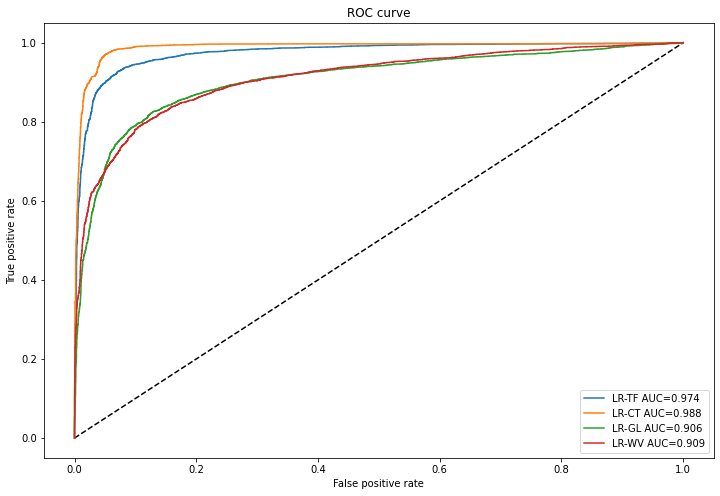

In [94]:
## Lets now plot the ROC curve for LR models
## We could see LR with count vectorizer and TF-IDF performs better
plt.figure(1,figsize=(12,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(logreg_tfidfVec[3], logreg_tfidfVec[4], label=f'LR-TF AUC={round(logreg_tfidfVec[1],3)}')
plt.plot(logreg_countVec[3], logreg_countVec[4], label=f'LR-CT AUC={round(logreg_countVec[1],3)}')
plt.plot(logreg_gloveVec[3], logreg_gloveVec[4], label=f'LR-GL AUC={round(logreg_gloveVec[1],3)}')
plt.plot(logreg_w2Vec[3], logreg_w2Vec[4], label=f'LR-WV AUC={round(logreg_w2Vec[1],3)}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

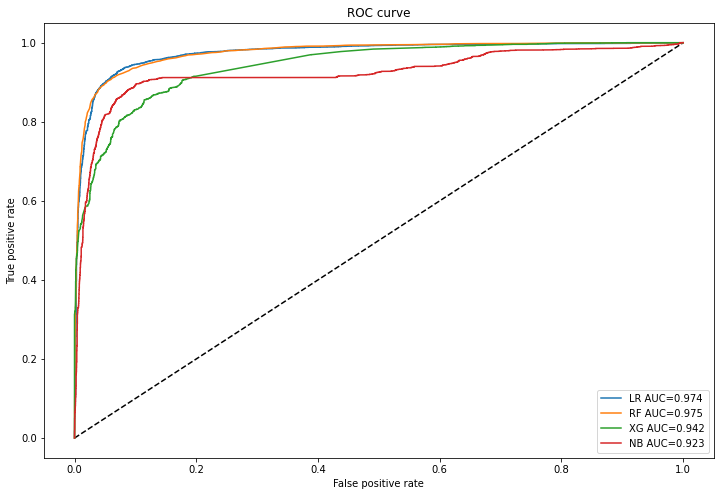

In [95]:
## Lets now plot the ROC curve for all the models
## We could see LR and Random Forst performs better 
plt.figure(1,figsize=(12,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(logreg_tfidfVec[3], logreg_tfidfVec[4], label=f'LR AUC={round(logreg_tfidfVec[1],3)}')
plt.plot(randForest_tfidfVec[3], randForest_tfidfVec[4], label=f'RF AUC={round(randForest_tfidfVec[1],3)}')
plt.plot(xgBoost_tfidfVec[3], xgBoost_tfidfVec[4], label=f'XG AUC={round(xgBoost_tfidfVec[1],3)}')
plt.plot(multi_nb_countVec[3], multi_nb_countVec[4], label=f'NB AUC={round(multi_nb_countVec[1],3)}')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Product Recommendation

### Now lets get the top 15 products from the Recommendation system.
### We are going to execute below models


*   User-based Recommendation system
*   Item-based Recommendation system



## Dividing the dataset into train and test

In [46]:
## Taking the required columns - username,brand(product) and ratings from the data set
df_recommend = pd.DataFrame(data = reviews[['reviews_username','id','reviews_rating']])
## Checking the data set
df_recommend.head()

,reviews_username,id,reviews_rating
0,joshua,AV13O1A8GV-KLJ3akUyj,5
1,dorothy w,AV14LG0R-jtxr-f38QfS,5
2,dorothy w,AV14LG0R-jtxr-f38QfS,5
3,rebecca,AV16khLE-jtxr-f38VFn,1
4,walker557,AV16khLE-jtxr-f38VFn,1


In [47]:
## If there are any duplicate ratings present for user and product combination then lets apply mean and take the average rating
df_recommend = df_recommend.groupby(['reviews_username','id'],as_index=False).agg({'reviews_rating':pd.Series.mode,'reviews_rating':np.mean})

In [48]:
## Changing column names for better understanding and representation
df_recommend['username'] = df_recommend['reviews_username']
df_recommend['product'] = df_recommend['id']
df_recommend['rating'] = round(df_recommend['reviews_rating'],1)
## Dropping the old columns and checking the data
df_recommend = df_recommend.drop(['reviews_username','id','reviews_rating'],axis=1)
df_recommend.head()

,username,product,rating
0,00dog3,AVpe6FfKilAPnD_xQmHi,4.0
1,00sab00,AVpe41TqilAPnD_xQH3d,1.0
2,00sab00,AVpe59io1cnluZ0-ZgDU,3.0
3,01impala,AVpfPaoqLJeJML435Xk9,3.0
4,02dakota,AVpfPaoqLJeJML435Xk9,5.0


In [52]:
## Splitting the data into train and test sets
train, test = train_test_split(df_recommend, test_size=0.2, random_state=seed)
## check the shape of the data sets
print(train.shape)
print(test.shape)

(22084, 3)
(5521, 3)


In [53]:
## checking the rating counts
df_recommend['rating'].value_counts()

5.0    19465
4.0     5430
3.0     1184
1.0     1050
2.0      369
4.5       51
3.5       12
4.7       11
4.3       10
4.2        6
4.8        4
1.5        2
2.5        2
4.6        2
3.7        2
3.3        1
3.6        1
4.4        1
3.4        1
2.1        1
Name: rating, dtype: int64

In [54]:
## Checking info of the data frame
df_recommend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27605 entries, 0 to 27604
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   username  27605 non-null  object 
 1   product   27605 non-null  object 
 2   rating    27605 non-null  float64
dtypes: float64(1), object(2)
memory usage: 862.7+ KB


In [55]:
# Apply pivot to see the user ratings for each product and give '0' wherever rating is not provided by the user
df_product_features = train.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(0)

In [56]:
## Checking the data set after pivoting the data frame
df_product_features.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Copy train and test dataset

### These dataset will be used for prediction and evaluation.


*   Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction.
*   Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train



In [57]:
## Taking the copy of train and test data sets
dummy_train = train.copy()
dummy_test = test.copy()

In [58]:
## Changing the rating value to '0' if the user provided rating
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)
## Changing the rating value to '1' if the user provided rating
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

In [59]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(1)

# The products not rated by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(0)

In [60]:
## Lets check the train data set
dummy_train.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [61]:
## Lets check the test data set
dummy_test.head()

product,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,...,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123cat123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123too,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# User based Similarity Matrix

### Using Cosine Similarity

In [62]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_product_features, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [63]:
## Checking the shape of the matrix
user_correlation.shape

(20254, 20254)

## Using adjusted Cosine

In [64]:
## Lets now create the product features data set and calculate the mean of the ratings provided by the user.
## This is used to calculate the cosine similarity
product_features = train.pivot(
    index='username',
    columns='product',
    values='rating'
)

In [65]:
## Checking the data
product_features.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the product for each user around 0 mean

In [66]:
## Getting the mean of the ratings provided by user and normalising
mean = np.nanmean(product_features, axis=1)
df_subtracted = (product_features.T-mean).T

In [67]:
df_subtracted.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [68]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Prediction

In [69]:
## Here we are going to recommend the products ti the user which are positively co-related with other users.
## So making '0' whichever is negative values
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
## Rating predicted by the user for products rated as well as not rated, is the weighted sum of correlation with the product rating as present in the dataset
user_predicted_ratings = np.dot(user_correlation, product_features.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.81257302,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [71]:
user_predicted_ratings.shape

(20254, 260)

In [72]:
## Now lets get the final recommendations of the products which are not rated by the user
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.0,1.154701,0.0,0.0,0.0,2.665009,0.82244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.140795,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.196972,3.040345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.523823,4.278752,0.0,2.5,0.0,0.0,0.67352,4.736068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215967,0.0,1.812573,0.204124
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
06stidriver,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


# Finding the top 15 recommendation for the user 1

In [74]:
user_final_rating.iloc[1].sort_values(ascending=False)[0:15]

product
AVpfPaoqLJeJML435Xk9    44.355240
AVpfRTh1ilAPnD_xYic2    31.127397
AVpf0eb2LJeJML43EVSt    26.883557
AVpf3VOfilAPnD_xjpun     7.500963
AVpfM_ytilAPnD_xXIJb     7.222364
AVpfJcHuLJeJML433ZrY     6.087544
AVpfBrUZilAPnD_xTUly     5.613743
AVpf5Z1zLJeJML43FpB-     5.425649
AVpf2tw1ilAPnD_xjflC     5.127829
AVpfrFDZLJeJML43Bmv0     4.736068
AVpfov9TLJeJML43A7B0     4.278752
AVpfPnrU1cnluZ0-g9rL     4.236068
AVpf385g1cnluZ0-s0_t     3.957697
AVpfOIrkilAPnD_xXgDG     3.943544
AVpe8gsILJeJML43y6Ed     3.790994
Name: 00sab00, dtype: float64

# Item Based Similarity

In [75]:
## Taking the transpose of the reviews matrix to normalize the rating around the mean for different product ID. 
## In the user based similarity, we had taken mean for each user intead of each product. 
product_features = train.pivot(
    index='username',
    columns='product',
    values='rating'
).T

product_features.head()

username,00dog3,00sab00,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234561,1234567,1234asdf,123charlie,123numbers,123rs,123soccermom,12cass12,12gage,132457,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,1753,18612,1863philly,1943,1950rmm,1970,1992firebirdgirl,19bubba67,...,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoe1988,zoey,zoeyny,zombie,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zotox,zowie,zozo0o,zpalma,zsarah,zsazsa,zt313,zubb,zuttle,zwithanx,zxjki,zzdiane,zzz1127
product,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
## Normalising the product rating for each product
mean = np.nanmean(product_features, axis=1)
df_subtracted = (product_features.T-mean).T

In [77]:
df_subtracted.head()

username,00dog3,00sab00,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234561,1234567,1234asdf,123charlie,123numbers,123rs,123soccermom,12cass12,12gage,132457,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,1753,18612,1863philly,1943,1950rmm,1970,1992firebirdgirl,19bubba67,...,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoe1988,zoey,zoeyny,zombie,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zotox,zowie,zozo0o,zpalma,zsarah,zsazsa,zt313,zubb,zuttle,zwithanx,zxjki,zzdiane,zzz1127
product,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.150391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
## Finding the cosine similarity. Note that since the data is normalised, both the cosine metric and correlation metric will give the same value. 
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [79]:
## Filtering the correlation only for which the value is greater than 0. (Positively correlated)
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Prediction

In [80]:
item_predicted_ratings = np.dot((product_features.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03458652,
        0.        ],
       [0.        , 0.        , 0.01153019, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0029185 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0576442 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00583699]])

In [81]:
item_predicted_ratings.shape

(20254, 260)

In [82]:
dummy_train.shape

(20254, 260)

### Filtering the rating only for the products not rated by the user for recommendation

In [83]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.020857,0.0,0.0,0.000000,0.034743,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.005956,0.0,0.0,0.000000,0.0,0.0,0.000000,0.002703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.016873,0.0,0.0,0.0,0.000000,0.0,0.0,0.014861,0.000000,0.0,0.007889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.002650,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.039377,0.000000,0.0,0.000000,0.0,0.0,0.011763,0.003766,0.000000,0.008078,0.0,0.0,0.0,0.0,0.038316,0.002263,0.0,0.034587,0.000000
02dakota,0.0,0.0,0.011530,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.001109,0.0,0.0,0.000000,0.007357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003628,0.0,0.0,0.0,0.0,0.0,0.009678,0.0,0.0,0.0,0.022219,0.0,0.0,0.000000,0.000000,0.0,0.007391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.015109,0.0,0.0,0.0,0.000000,0.004816,0.0,0.010611,0.0,0.0,0.013621,0.003528,0.122005,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.009224,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000887,0.0,0.0,0.000000,0.005886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002903,0.0,0.0,0.0,0.0,0.0,0.007742,0.0,0.0,0.0,0.017775,0.0,0.0,0.000000,0.000000,0.0,0.005913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.012087,0.0,0.0,0.0,0.000000,0.003853,0.0,0.008489,0.0,0.0,0.010896,0.002823,0.097604,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
06stidriver,0.0,0.0,0.000000,0.003866,0.0,0.0,0.0,0.002081,0.003646,0.0,0.0,0.000000,0.0,0.0,0.005008,0.002404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001918,0.0,0.0,0.0,0.0,0.0,0.008913,0.0,0.0,0.0,0.000066,0.0,0.0,0.000000,0.001781,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00402,0.006478,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.001207,0.0021

## Top 15 prediction for the user -1

In [88]:
item_final_rating.iloc[1].sort_values(ascending=False)[0:15]

product
AVpfE7puilAPnD_xUcCW    0.120537
AVpfNc9cLJeJML434tza    0.042088
AVpf5ujMilAPnD_xkQVi    0.040216
AVpfoSS51cnluZ0-oVH9    0.039377
AVpfthSailAPnD_xg3ON    0.038316
AVpfv4TlilAPnD_xhjNS    0.034587
AVpe6FfKilAPnD_xQmHi    0.031271
AVpe6PCDLJeJML43yFQH    0.029658
AVpfOmKwLJeJML435GM7    0.025282
AVpfJcHuLJeJML433ZrY    0.023106
AVpf0thK1cnluZ0-r8vR    0.021604
AVpf7aUAilAPnD_xkqbP    0.018944
AVpf9_3MLJeJML43GvdB    0.018559
AVpe8gsILJeJML43y6Ed    0.017407
AVpe31o71cnluZ0-YrSD    0.016873
Name: 00sab00, dtype: float64

# Evaluation

### Here lets evaluate for the product which is already rated by the user insead of predicting it for the product not rated by the user. 

## Using User Similarity

In [89]:
test_product_features = test.pivot(
    index='username',
    columns='product',
    values='rating'
)
mean = np.nanmean(test_product_features, axis=1)
test_df_subtracted = (test_product_features.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [90]:
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = np.dot(test_user_correlation, test_product_features.fillna(0))
test_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Doing prediction for the products rated by the user

In [91]:
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [92]:
test_user_final_rating.head()

product,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,...,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123cat123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123too,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [93]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [94]:
test_ = test.pivot(
    index='username',
    columns='product',
    values='rating'
)

In [95]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

## Finding RMSE

In [96]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.4233688213575233


### In the above RMSE for user based recomender system is more.

# Using Item similarity

In [97]:
test_product_features = test.pivot(
    index='username',
    columns='product',
    values='rating'
).T

mean = np.nanmean(test_product_features, axis=1)
test_df_subtracted = (test_product_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [98]:
test_item_correlation.shape

(193, 193)

In [99]:
test_product_features.shape

(193, 5355)

In [100]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_product_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

product,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,...,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123cat123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123too,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
test_ = test.pivot(
    index='username',
    columns='product',
    values='rating'
)

In [102]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='username',
    columns='product',
    values='rating'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

MinMaxScaler(copy=True, feature_range=(1, 5))


# Finding RMSE

In [103]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

0.38860832588224853


## RMSE value for Item based recommender system is less and predicting better than user based recommender system. So we can conclude that, Item based is performing well in recommending the products for the users